(10, 1, 6, 9997)
(10, 1, 6, 9997)


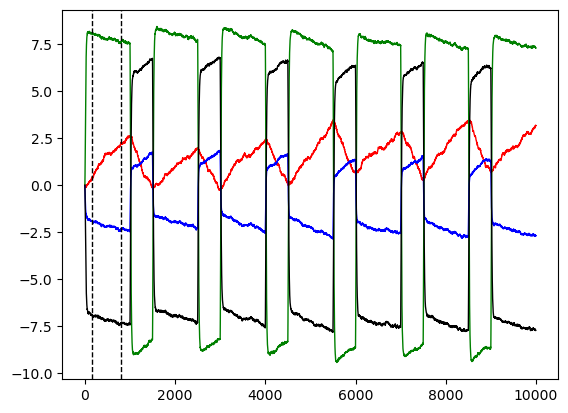

In [ ]:

from toolbox import OneDModel_TBK as ODM
import importlib
importlib.reload(ODM)

Temps_ori, F, Fadv = ODM.OneDModel(wnoise_level = 0.01, if_shift=True, lag_multiplier=2, show_figures=False)

import matplotlib.pyplot as plt
import numpy as np


# Resample by taking every 10th value along the time dimension
# Temps = Temps_ori[:, :, :, ::10]

Temps=Temps_ori

time = np.arange(1, len(np.squeeze(Temps[0, 0, 1, :])) + 1)

plt.figure()
idx=3
# Last loop (i == 10), plot in black
plt.plot(time, Temps[idx, 0, 1, :], 'r', linewidth=1)
plt.plot(time, Temps[idx, 0, 2, :], 'g', linewidth=1)
plt.plot(time, Temps[idx, 0, 3, :], 'b', linewidth=1)
plt.plot(time, Temps[idx, 0, 4, :], 'k', linewidth=1)

# plot vertical lies at time =190 and 210
# plt.axvline(x=160, color='k', linestyle='--', linewidth=1)
# plt.axvline(x=240, color='k', linestyle='--', linewidth=1)

plt.axvline(x=160, color='k', linestyle='--', linewidth=1)
plt.axvline(x=800, color='k', linestyle='--', linewidth=1)

# print the shape of original data and resampled data
print(Temps_ori.shape)
print(Temps.shape)

Text(0, 0.5, 'Temperature')

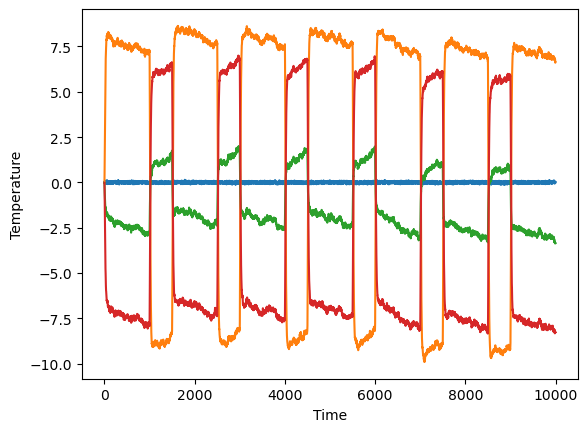

In [15]:
idx = 4  # Index of the last simulation without noise
# Convert the dictionary to an array suitable for Tigramite's DataFrame
data_array = Temps[idx, 0, 1:5, :].T.copy()

# For data_array, for the first column, replace it with its derivative
first_col_diff = np.diff(data_array[:, 0])
# drop the last row of data_array
data_array = data_array[:-1, :]
data_array[:, 0] = first_col_diff

time = np.arange(1, len(np.squeeze(Temps[0, 0, 1, :])) )

# plot the data_array time series
import matplotlib.pyplot as plt
plt.plot(time, data_array)
plt.xlabel('Time')
plt.ylabel('Temperature')

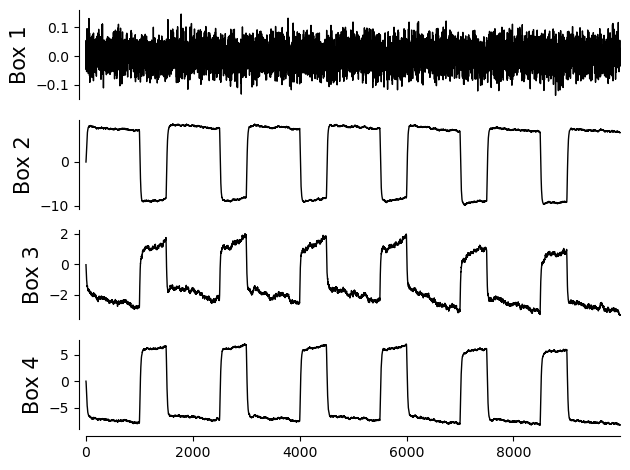

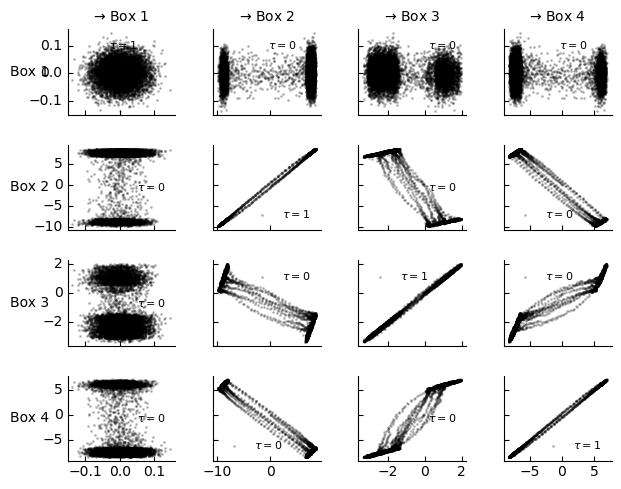


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


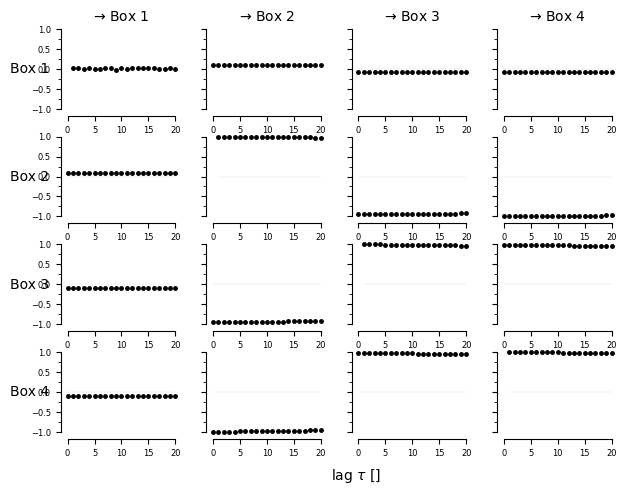


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable Box 1 has 6 link(s):
    [pc_alpha = 0.4]
        (Box 1 -5): max_pval = 0.10967, |min_val| =  0.016
        (Box 1 -2): max_pval = 0.13395, |min_val| =  0.015
        (Box 1 -4): max_pval = 0.15127, |min_val| =  0.014
        (Box 2 -3): max_pval = 0.33452, |min_val| =  0.010
        (Box 1 -8): max_pval = 0.36622, |min_val| =  0.009
        (Box 2 -5): max_pval = 0.39773, |min_val| =  0.008

    Variable Box 2 has 17 link(s):
    [pc_alpha = 0.5]
        (Box 2 -1): max_pval = 0.00000, |min_val| =  0.773
        (Box 2 -5): max_pval = 0.00000, |min_val| =  0.057
        (Box 2 -3): max_pval = 0.00012, |min_val| =  0.039
        (Box 2 -4): max_pval = 0.00110, |min_val| =  0.033
        (Box 3 -5): max_pval = 0.00438,

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

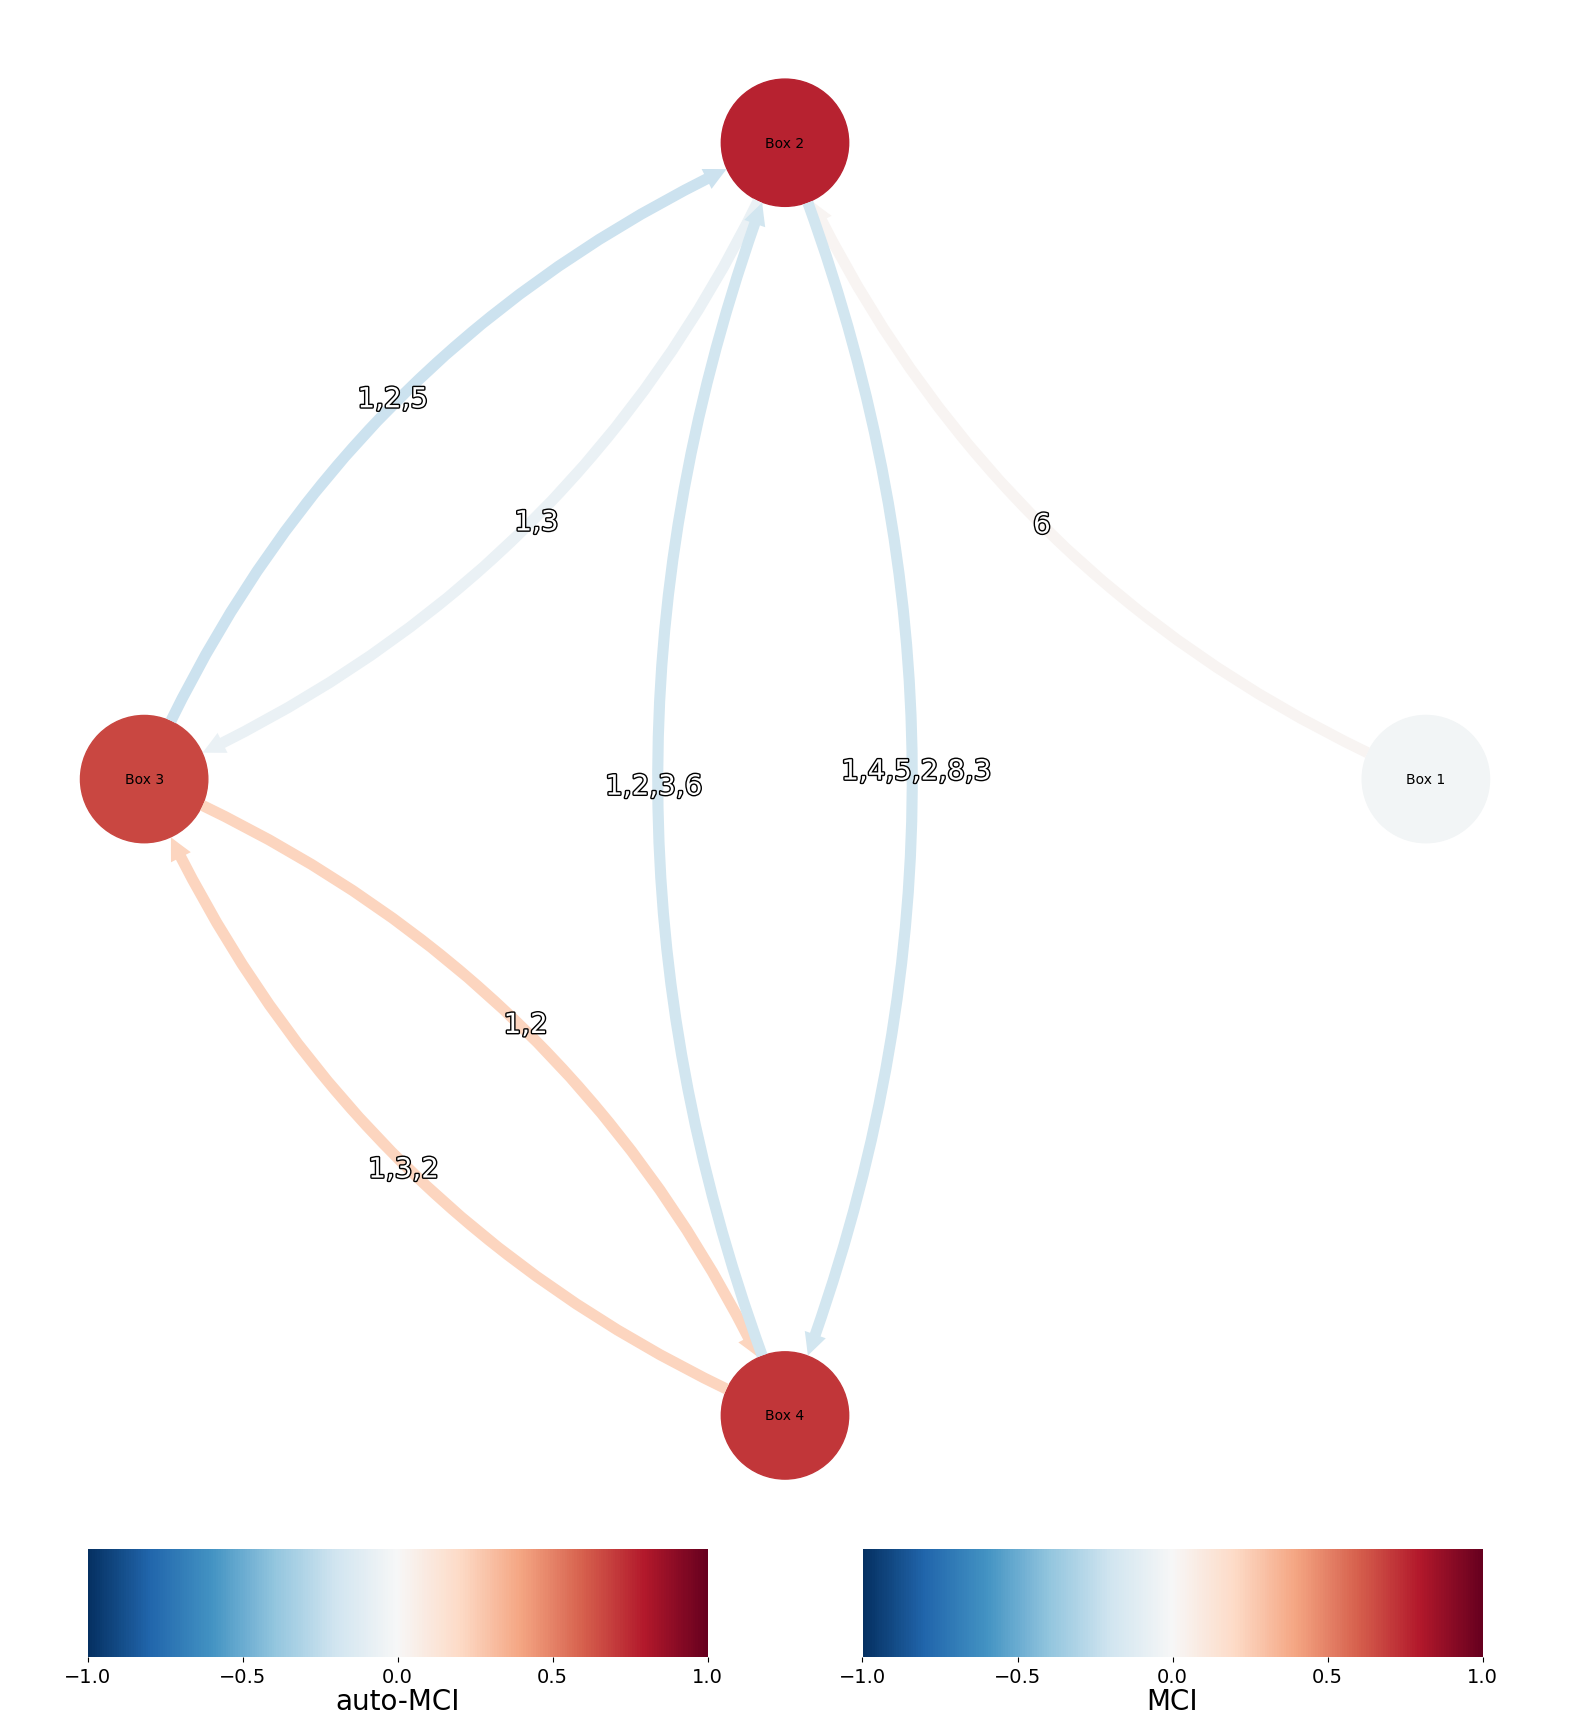

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn
import pandas as pd

# Create a Tigramite DataFrame object
var_names = [f"Box {k+1}" for k in range(4)]

# create adataframe called 'df4stationary_check' with the data_array and the variable names
df4stationary_check= pd.DataFrame(data_array, columns=var_names)

dataframe_TEMP = pp.DataFrame(data_array, datatime=np.arange(data_array.shape[0]), var_names=var_names)
tp.plot_timeseries(dataframe_TEMP,label_fontsize=15,tick_label_size=10)





ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe_TEMP,
    cond_ind_test=ParCorr,
    verbosity=1)


matrix_lags = None #np.argmax(np.abs(correlations), axis=2)
tp.plot_scatterplots(dataframe=dataframe_TEMP, add_scatterplot_args={'matrix_lags':matrix_lags}); plt.show()
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

pcmci.verbosity = 1
tau_min=1
tau_max=8
results = pcmci.run_pcmci(tau_min=tau_min, tau_max=tau_max, pc_alpha=None)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )

Text(0, 0.5, 'Temperature')

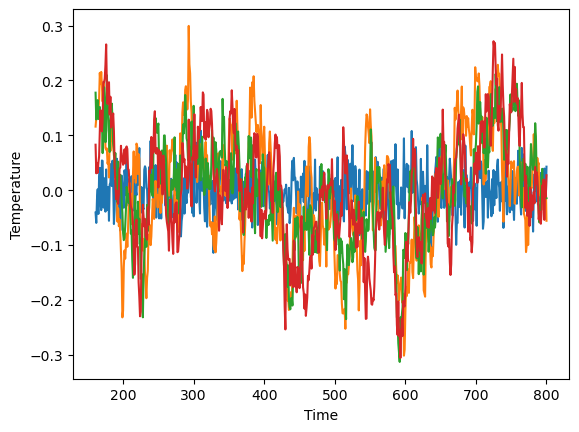

In [17]:
idx = 4  # Index of the last simulation without noise
# Convert the dictionary to an array suitable for Tigramite's DataFrame
data_array = Temps[idx, 0, 1:5, :].T.copy()



# For data_array, for the first column, replace it with its derivative
first_col_diff = np.diff(data_array[:, 0])
# drop the last row of data_array
data_array = data_array[:-1, :]
data_array[:, 0] = first_col_diff

time = np.arange(1, len(np.squeeze(Temps[0, 0, 1, :])) )

# crop the data between time = 160 and 240
data_array = data_array[160:800, :]
# crop the time array between time = 160 and 240
time = time[160:800]

# detrend each column of the data_array using detrend function
from scipy.signal import detrend
data_array = detrend(data_array, axis=0)


# plot the data_array time series
import matplotlib.pyplot as plt
plt.plot(time, data_array)
plt.xlabel('Time')
plt.ylabel('Temperature')

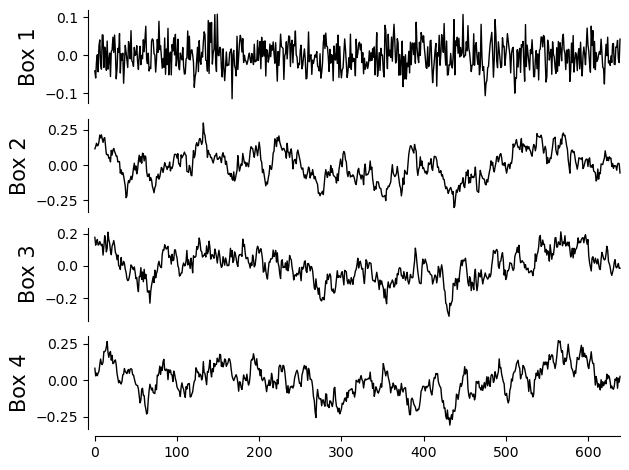

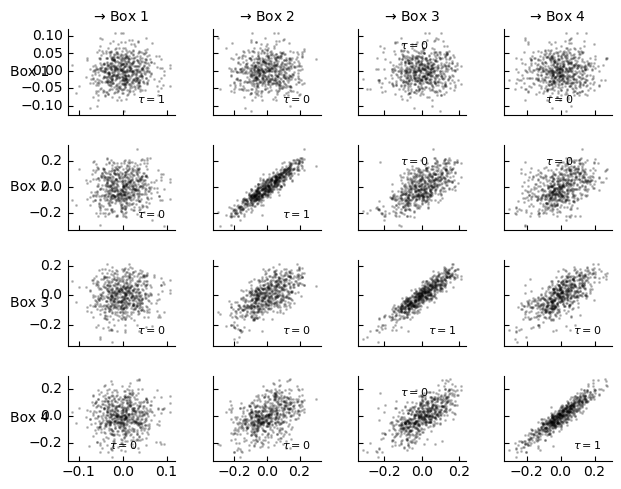


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


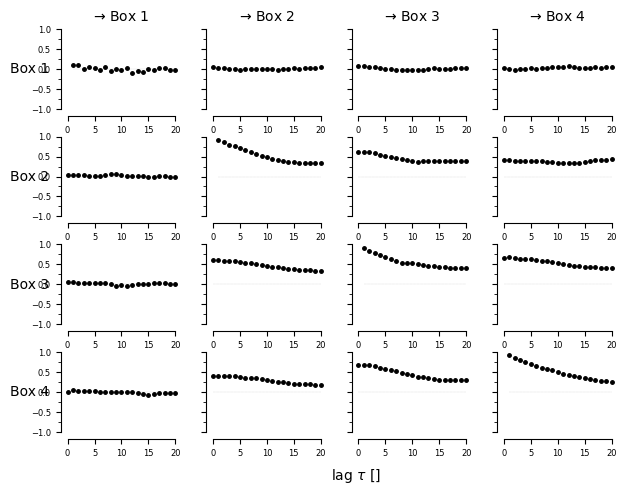


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 8
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable Box 1 has 2 link(s):
    [pc_alpha = 0.1]
        (Box 1 -2): max_pval = 0.04011, |min_val| =  0.082
        (Box 1 -1): max_pval = 0.06333, |min_val| =  0.074

    Variable Box 2 has 3 link(s):
    [pc_alpha = 0.1]
        (Box 2 -1): max_pval = 0.00000, |min_val| =  0.666
        (Box 3 -2): max_pval = 0.04081, |min_val| =  0.082
        (Box 3 -1): max_pval = 0.07275, |min_val| =  0.072

    Variable Box 3 has 6 link(s):
    [pc_alpha = 0.5]
        (Box 3 -1): max_pval = 0.00000, |min_val| =  0.651
        (Box 4 -1): max_pval = 0.00000, |min_val| =  0.205
        (Box 2 -1): max_pval = 0.00005, |min_val| =  0.163
        (Box 2 -5): max_pval = 0.26785, |min_val| =  0.044
        (Box 2 -2): max_pval = 0.33892, |mi

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

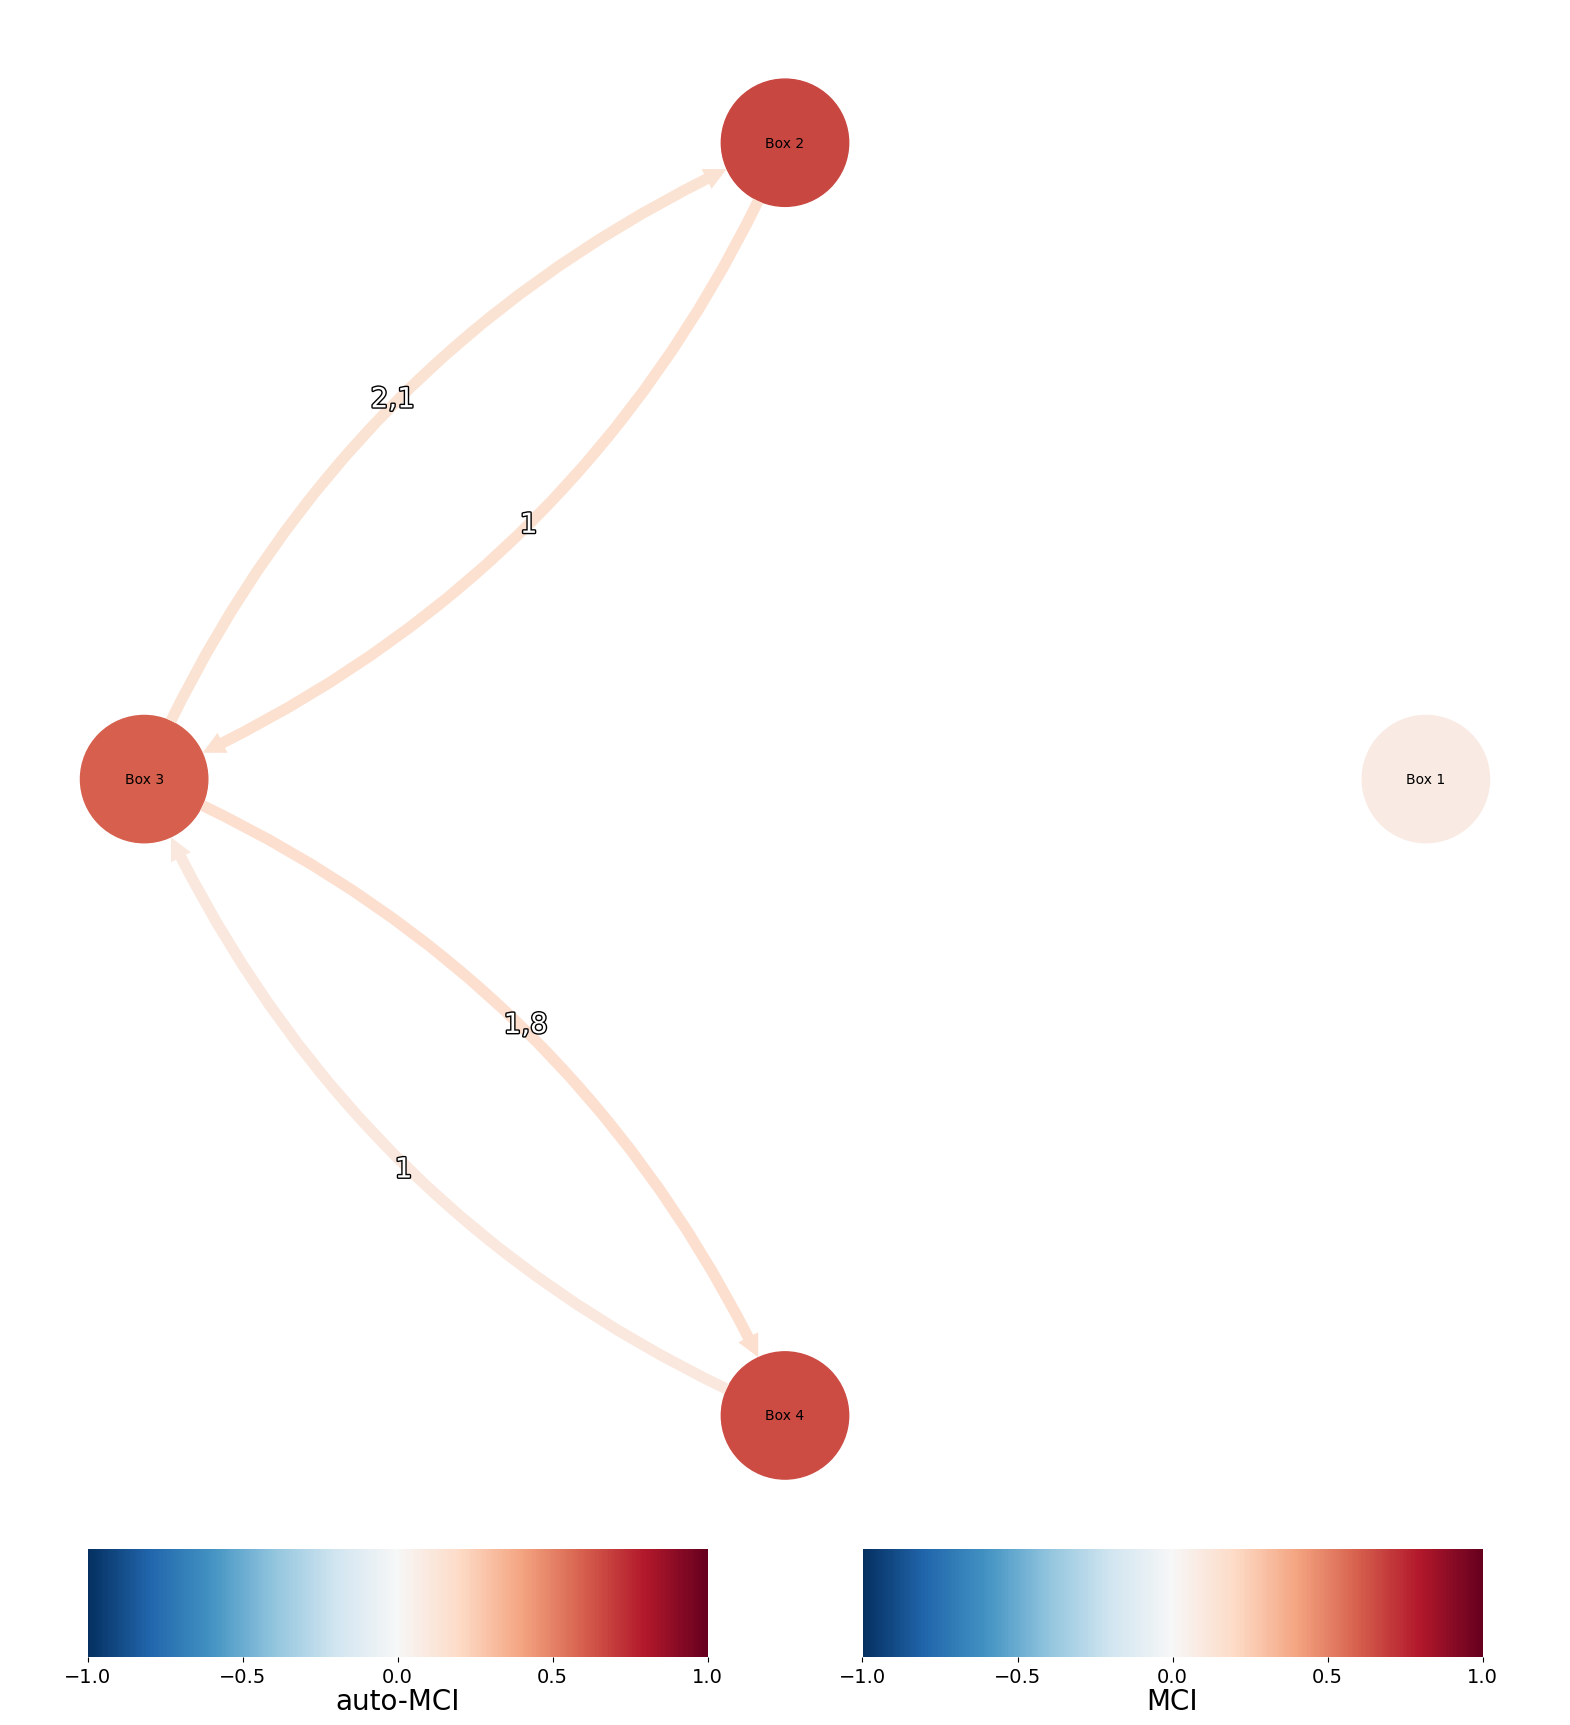

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn
import pandas as pd

# Create a Tigramite DataFrame object
var_names = [f"Box {k+1}" for k in range(4)]

# create adataframe called 'df4stationary_check' with the data_array and the variable names
df4stationary_check= pd.DataFrame(data_array, columns=var_names)

dataframe_TEMP = pp.DataFrame(data_array, datatime=np.arange(data_array.shape[0]), var_names=var_names)
tp.plot_timeseries(dataframe_TEMP,label_fontsize=15,tick_label_size=10)





ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe_TEMP,
    cond_ind_test=ParCorr,
    verbosity=1)


matrix_lags = None #np.argmax(np.abs(correlations), axis=2)
tp.plot_scatterplots(dataframe=dataframe_TEMP, add_scatterplot_args={'matrix_lags':matrix_lags}); plt.show()
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

pcmci.verbosity = 1
tau_min=1
tau_max=8
results = pcmci.run_pcmci(tau_min=tau_min, tau_max=tau_max, pc_alpha=None)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )